<a href="https://colab.research.google.com/github/billycemerson/quantitative-finance-project/blob/main/02_traditional_ts/multivariate_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Library & Package

In [1]:
!pip install yfinance statsmodels

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import (
    coint_johansen,
    VECM
)
from statsmodels.tsa.stattools import grangercausalitytests

#### Data

We will use data from the stock BBCA, IHSG, and USDIDR.

In [3]:
start_date = "2021-01-01"
end_date   = "2024-12-31"

bbca  = yf.download("BBCA.JK", start=start_date, end=end_date, progress=False)[['Close']]
ihsg  = yf.download("^JKSE",   start=start_date, end=end_date, progress=False)[['Close']]
usdidr = yf.download("USDIDR=X", start=start_date, end=end_date, progress=False)[['Close']]

/tmp/ipython-input-3777149965.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bbca  = yf.download("BBCA.JK", start=start_date, end=end_date, progress=False)[['Close']]
/tmp/ipython-input-3777149965.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ihsg  = yf.download("^JKSE",   start=start_date, end=end_date, progress=False)[['Close']]
/tmp/ipython-input-3777149965.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  usdidr = yf.download("USDIDR=X", start=start_date, end=end_date, progress=False)[['Close']]


In [4]:
df = pd.concat([bbca, ihsg, usdidr], axis=1)
df.columns = ["BBCA", "IHSG", "USDIDR"]
df = df.dropna()
df.head()

,BBCA,IHSG,USDIDR
Date,,,
2021-01-04,6028.375000,6104.897949,14022.500977
2021-01-05,6253.281250,6137.342773,13931.400391
2021-01-06,6125.392578,6065.682129,13930.000000
2021-01-07,6143.033203,6153.632812,13951.500000
2021-01-08,6218.001465,6257.834961,13892.977539


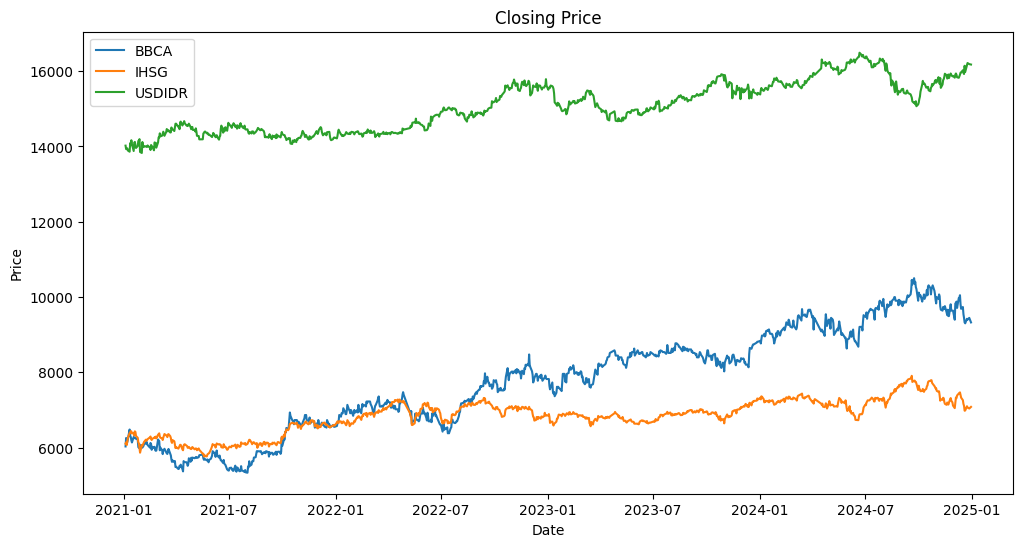

In [12]:
# Data plot
plt.figure(figsize=(12,6))
plt.plot(df.index, df['BBCA'])
plt.plot(df.index, df['IHSG'])
plt.plot(df.index, df['USDIDR'])
plt.title("Closing Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(["BBCA", "IHSG", "USDIDR"])
plt.show()

#### Log Returns

In [5]:
returns = np.log(df).diff().dropna()
returns.head()

,BBCA,IHSG,USDIDR
Date,,,
2021-01-05,0.036629,0.005300,-0.006518
2021-01-06,-0.020663,-0.011745,-0.000101
2021-01-07,0.002876,0.014396,0.001542
2021-01-08,0.012130,0.016792,-0.004204
2021-01-11,0.040992,0.019794,-0.002276


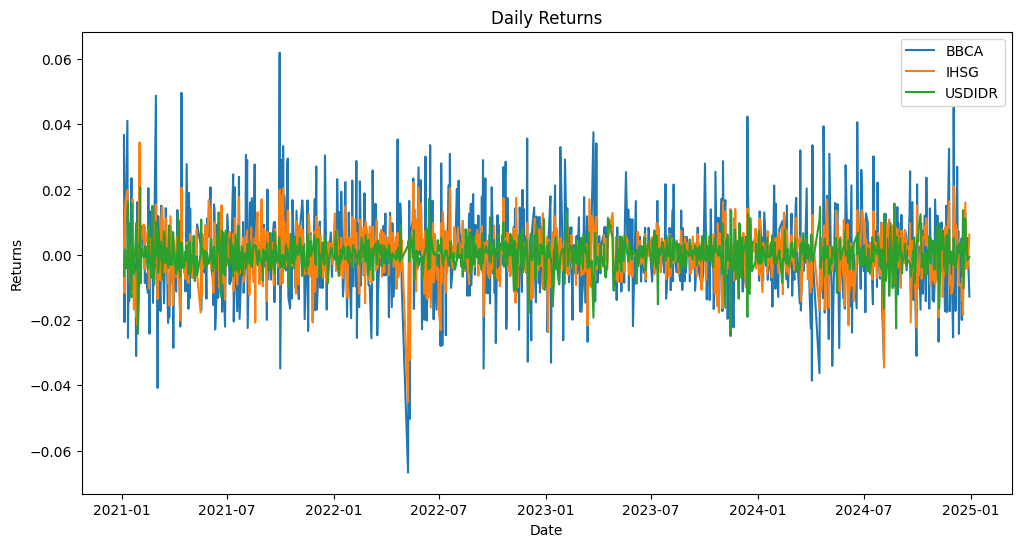

In [11]:
# Return plot
plt.figure(figsize=(12,6))
plt.plot(returns.index, returns['BBCA'])
plt.plot(returns.index, returns['IHSG'])
plt.plot(returns.index, returns['USDIDR'])
plt.title("Daily Returns")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend(["BBCA", "IHSG", "USDIDR"])
plt.show()

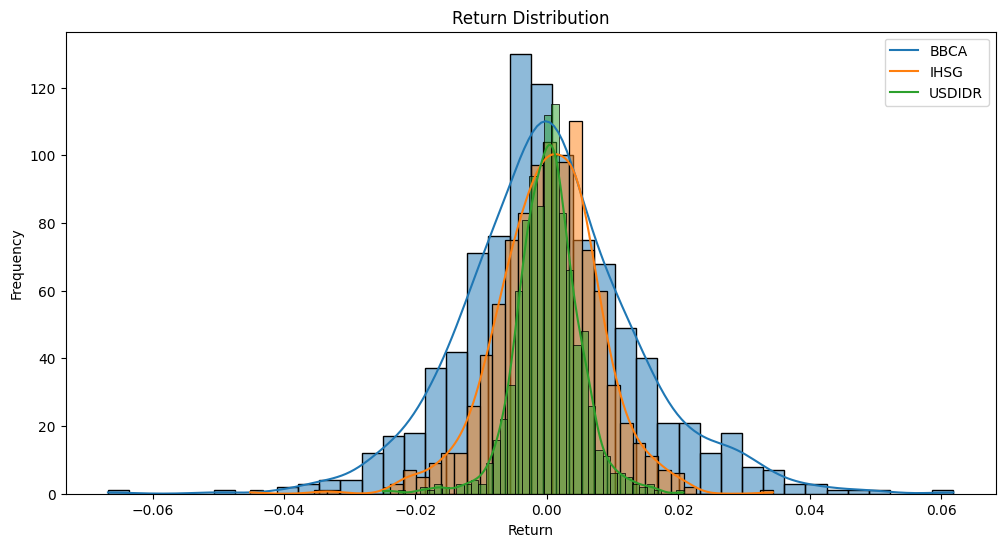

In [34]:
# Return distribution
plt.figure(figsize=(12,6))
sns.histplot(returns['BBCA'], kde=True)
sns.histplot(returns['IHSG'], kde=True)
sns.histplot(returns['USDIDR'], kde=True)
plt.title("Return Distribution")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.legend(["BBCA", "IHSG", "USDIDR"])
plt.show()

#### Stationarity Check (ADF)

In [29]:
def adf_test(series, name):
    result = adfuller(series)
    print(f"{name}")
    print(f"ADF Statistic : {result[0]:.4f}")
    print(f"p-value       : {result[1]:.4f}")

for col in returns.columns:
    adf_test(returns[col], col)

BBCA
ADF Statistic : -25.3479
p-value       : 0.0000
IHSG
ADF Statistic : -32.7015
p-value       : 0.0000
USDIDR
ADF Statistic : -9.0387
p-value       : 0.0000


Because the p-value is < 0.05 than it can reject the nulll hypotesis.

It means that the time series is likely stationary.

#### Lag Selection for Vector Autoregression (VAR)

In [13]:
model = VAR(returns)

lag_order_results = model.select_order(maxlags=10)
lag_order_results.summary()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-29.41,-29.40,1.687e-13,-29.40
1,-29.48,-29.42*,1.570e-13,-29.46
2,-29.51*,-29.41,1.525e-13*,-29.47*
3,-29.51,-29.36,1.530e-13,-29.45
4,-29.51,-29.31,1.531e-13,-29.43
5,-29.51,-29.27,1.529e-13,-29.42
6,-29.50,-29.21,1.550e-13,-29.38
7,-29.49,-29.16,1.553e-13,-29.37
8,-29.48,-29.10,1.576e-13,-29.33
9,-29.47,-29.04,1.594e-13,-29.30


In [14]:
# Optimal lag
optimal_lag = lag_order_results.aic
print("Optimal lag (AIC):", optimal_lag)

Optimal lag (AIC): 2


#### Fit VAR Model

In [15]:
var_model = model.fit(optimal_lag)
print(var_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 29, Dec, 2025
Time:                     16:21:41
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -29.3638
Nobs:                     966.000    HQIC:                  -29.4294
Log likelihood:           10142.8    FPE:                1.59027e-13
AIC:                     -29.4697    Det(Omega_mle):     1.55620e-13
--------------------------------------------------------------------
Results for equation BBCA
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.000568         0.000429            1.326           0.185
L1.BBCA          -0.217955         0.039881           -5.465           0.000
L1.IHSG           0.069751         0.067862            1.028           0.304


Some key insight from VAR model result:
- The BBCA returns is influenced by its own momentum (lag) negatively and its not statisticaly influenced by the lag of IHSG and USDIDR.
- The returns of IHSG is cannot be predicted by its own lag, BBCA, or USDIDR.
- The USDIDR returns is statisticaly influenced by its own lag and stock market movement (BBCA and IHSG).


#### VAR Stability Check

In [16]:
var_model.is_stable(verbose=True)

Eigenvalues of VAR(1) rep
0.19750718211153181
0.19750718211153181
0.30137956410206435
0.30137956410206435
0.4076490115866161
0.4076490115866161


np.True_

All roots value < 1, so it can be concluded that the model is stable.

#### Granger Causality Tests

In [18]:
max_lag = optimal_lag

for caused in returns.columns:
    for causing in returns.columns:
        if caused != causing:
            print(f"\n{causing} → {caused}")
            grangercausalitytests(
                returns[[caused, causing]],
                maxlag=max_lag
            )


IHSG → BBCA

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1761  , p=0.2784  , df_denom=964, df_num=1
ssr based chi2 test:   chi2=1.1797  , p=0.2774  , df=1
likelihood ratio test: chi2=1.1790  , p=0.2776  , df=1
parameter F test:         F=1.1761  , p=0.2784  , df_denom=964, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9497  , p=0.3872  , df_denom=961, df_num=2
ssr based chi2 test:   chi2=1.9092  , p=0.3850  , df=2
likelihood ratio test: chi2=1.9073  , p=0.3853  , df=2
parameter F test:         F=0.9497  , p=0.3872  , df_denom=961, df_num=2

USDIDR → BBCA

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4064  , p=0.2359  , df_denom=964, df_num=1
ssr based chi2 test:   chi2=1.4108  , p=0.2349  , df=1
likelihood ratio test: chi2=1.4098  , p=0.2351  , df=1
parameter F test:         F=1.4064  , p=0.2359  , df_denom=964, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:   

Here some point from the result:
- There is no significant p-value for IHSG -> BBCA. It means that IHSG historical data does NOT contain additional information to predict BBCA stock movements outside of information from BBCA itself.
- There is no significant p-value for USDIDR -> BBCA. It means that USDIDR historical data does NOT contain additional information to predict BBCA stock movements outside of information from BBCA itself.
- There is no significant p-value for BBCA -> IHSG. It means that BBCA stock movements do NOT predict the overall movement of the IHSG index.
- There is no significant p-value for USDIDR -> IHSG. It means that USDIDR data movements do NOT predict the overall movement of the IHSG index.
- There is significat p-value for BBCA -> USDIDR in Lag 2. It menas that BBCA movement takes 2 periods to affect the exchange rate.
- There is significat p-value for BBCA -> USDIDR in Lag 1 and 2. It menas that IHSG is very strong in predicting USDIDR movements.

#### Impulse Response Function (VAR)

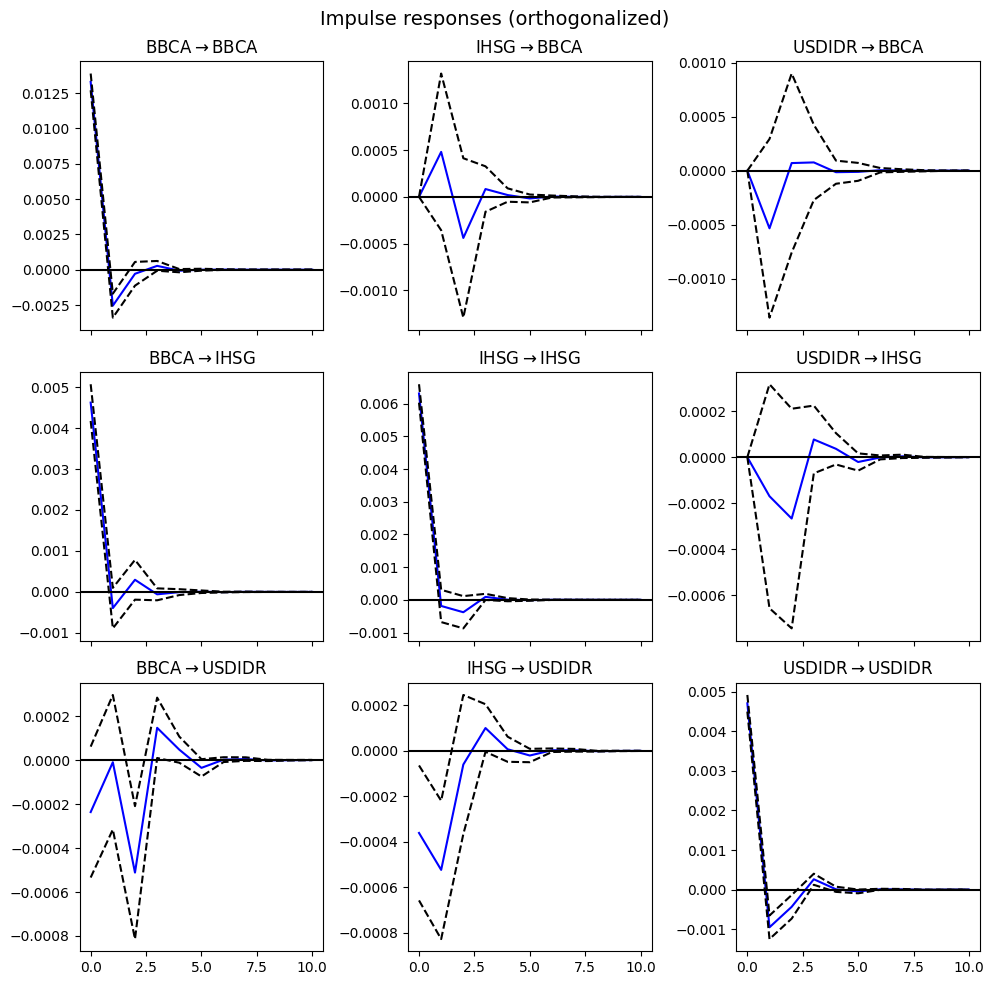

In [25]:
irf = var_model.irf(10)
irf.plot(orth=True)
plt.tight_layout()
plt.show()

#### Cointegration Test (Johansen)

In [26]:
# Use the log price data
log_prices = np.log(df).dropna()

In [28]:
johansen_test = coint_johansen(
    log_prices,
    det_order=0,
    k_ar_diff=optimal_lag
)

trace_stat = johansen_test.lr1
crit_values = johansen_test.cvt

for i in range(len(trace_stat)):
    print(f"r = {i}")
    print(f"Trace stat : {trace_stat[i]:.2f}")
    print(f"Critical (95%): {crit_values[i,1]}")

r = 0
Trace stat : 24.01
Critical (95%): 29.7961
r = 1
Trace stat : 11.93
Critical (95%): 15.4943
r = 2
Trace stat : 0.92
Critical (95%): 3.8415


The result shows that all of the trace stat value < critical value

This mean that there is no cointegration on the BBCA, IHSG, and USDIDR.

But for example and exploring Vector Error Vector Error Correction Models (VECM) we just continue the analysis.

#### Fit VECM

In [30]:
vecm_model = VECM(
    log_prices,
    k_ar_diff=optimal_lag,
    coint_rank=1,
    deterministic="co"
)

vecm_result = vecm_model.fit()
print(vecm_result.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Det. terms outside the coint. relation & lagged endog. parameters for equation BBCA
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1578      0.178     -0.884      0.377      -0.508       0.192
L1.BBCA       -0.2156      0.040     -5.416      0.000      -0.294      -0.138
L1.IHSG        0.0662      0.068      0.977      0.329      -0.067       0.199
L1.USDIDR     -0.1221      0.090     -1.357      0.175      -0.298       0.054
L2.BBCA       -0.0389      0.040     -0.980      0.327      -0.117       0.039
L2.IHSG       -0.0649      0.068     -0.952      0.341      -0.198       0.069
L2.USDIDR     -0.0369      0.089     -0.414      0.679      -0.212       0.138
Det. terms outside the coint. relation & lagged endog. parameters for equation IHSG
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------

#### Error Correction Interpretation

In [35]:
vecm_result.alpha

array([[-0.00545616],
       [ 0.00721528],
       [ 0.00223985]])

#### VECM Impulse Response

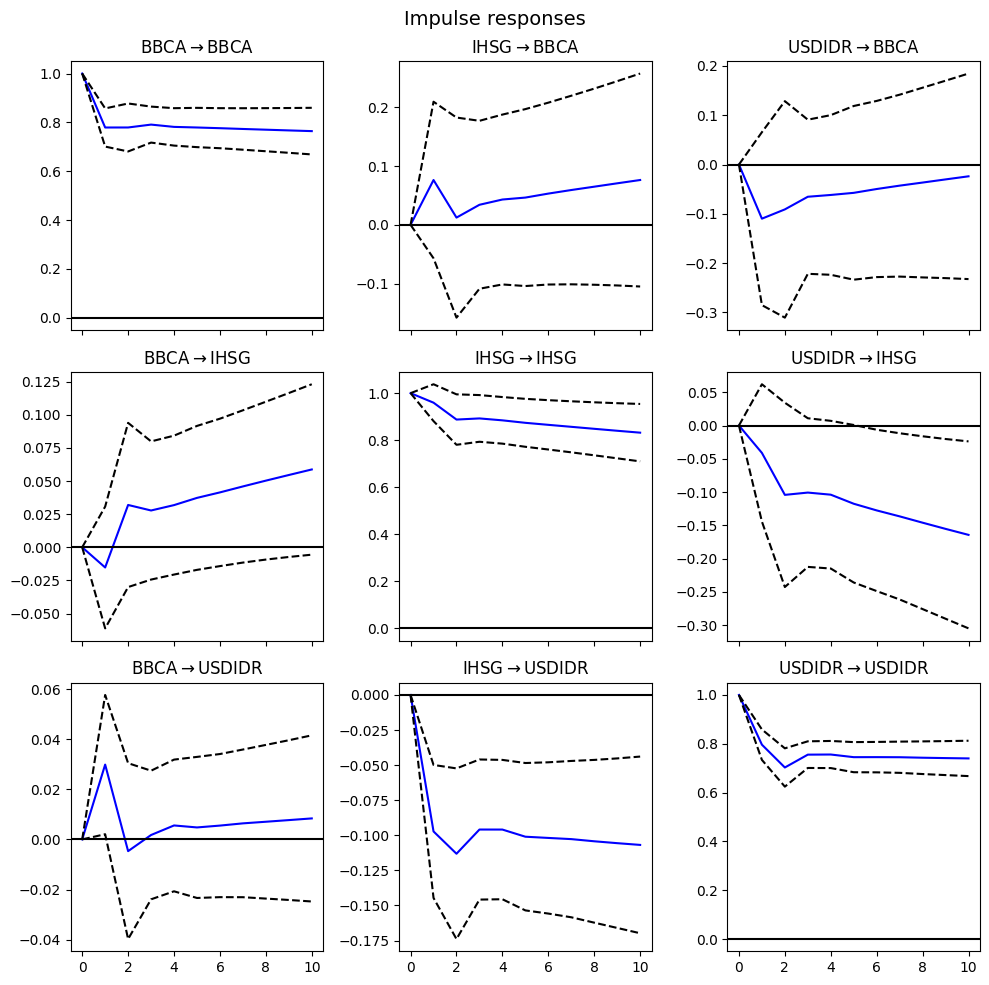

In [36]:
vecm_irf = vecm_result.irf(10)
vecm_irf.plot()
plt.tight_layout()
plt.show()

#### Forecasting with VAR (Returns)

In [38]:
split_idx = -30  # last 30 observations for test

train_data = returns.iloc[:split_idx]
test_data  = returns.iloc[split_idx:]

In [39]:
horizon = len(test_data)

var_forecast = var_model.forecast(
    y=train_data.values[-optimal_lag:],
    steps=horizon
)

forecast_df = pd.DataFrame(
    var_forecast,
    columns=train_data.columns,
    index=test_data.index
)

forecast_df.head()

,BBCA,IHSG,USDIDR
Date,,,
2024-11-14,-0.000832,-0.000437,-0.001452
2024-11-15,0.000951,0.000282,0.000405
2024-11-18,0.000440,0.000233,0.000375
2024-11-19,0.000378,0.000143,0.000051
2024-11-20,0.000447,0.000143,0.000142


In [40]:
forecast_bbca = forecast_df['BBCA']
train_bbca = train_data['BBCA']
test_bbca  = test_data['BBCA']

In [41]:
def plot_var_full_history(
    train_series,
    test_series,
    forecast_series,
    ticker
):
    plt.figure(figsize=(12, 6))

    plt.plot(
        train_series.index,
        train_series.values,
        label='Training Data'
    )

    plt.plot(
        test_series.index,
        test_series.values,
        label='Actual',
        color='black'
    )

    plt.plot(
        forecast_series.index,
        forecast_series.values,
        label='Forecast',
        color='red'
    )

    plt.title(f'{ticker} - VAR Forecast (Full History)')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [42]:
def plot_var_zoomed(
    train_series,
    test_series,
    forecast_series,
    ticker,
    zoom_window=50
):
    zoom_start = train_series.index[-zoom_window]

    plt.figure(figsize=(12, 6))

    plt.plot(
        train_series.loc[zoom_start:].index,
        train_series.loc[zoom_start:].values,
        label='Training Data'
    )

    plt.plot(
        test_series.index,
        test_series.values,
        label='Actual',
        color='black'
    )

    plt.plot(
        forecast_series.index,
        forecast_series.values,
        label='Forecast',
        color='red'
    )

    plt.xlim(
        zoom_start,
        test_series.index[-1]
    )

    plt.title(f'{ticker} - Zoomed VAR Forecast')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

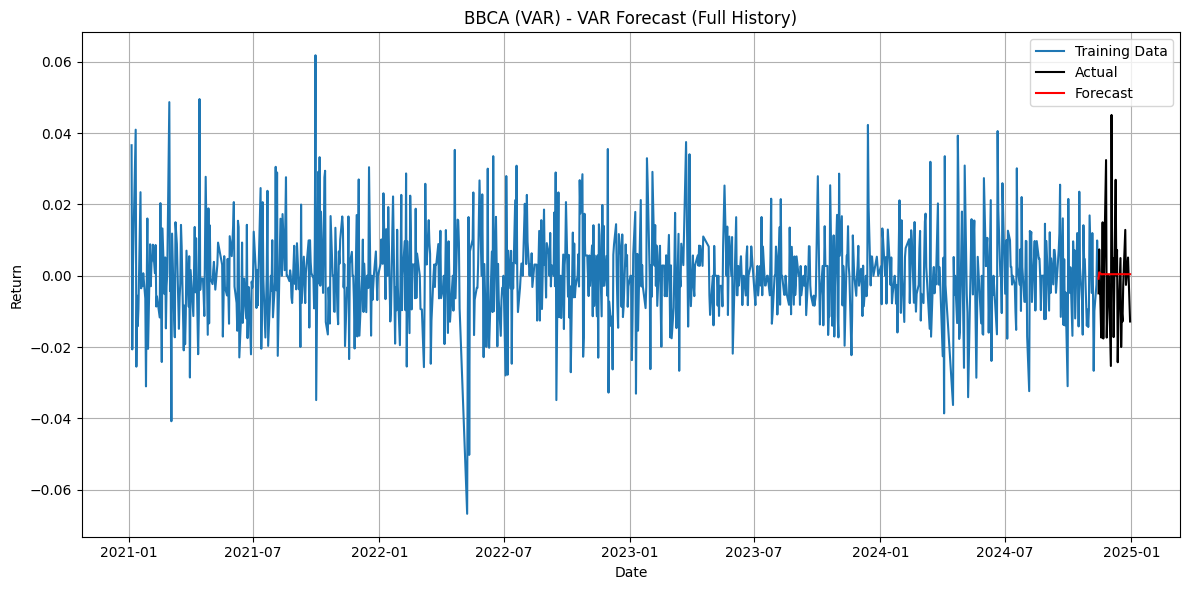

In [43]:
plot_var_full_history(
    train_series=train_bbca,
    test_series=test_bbca,
    forecast_series=forecast_bbca,
    ticker="BBCA (VAR)"
)

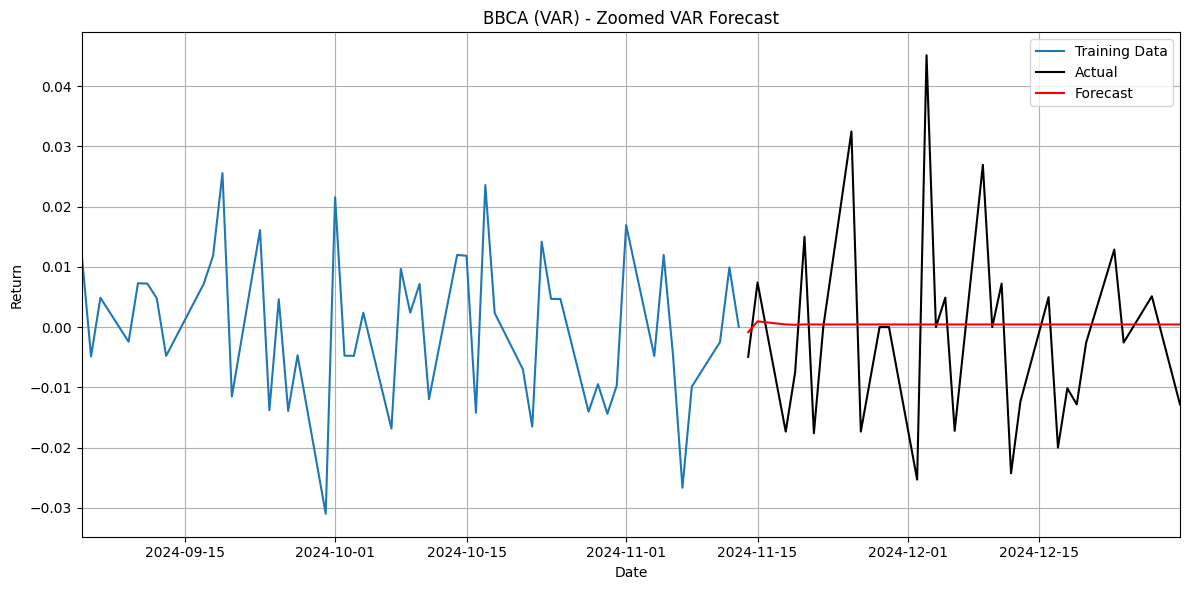

In [44]:
plot_var_zoomed(
    train_series=train_bbca,
    test_series=test_bbca,
    forecast_series=forecast_bbca,
    ticker="BBCA (VAR)",
    zoom_window=50
)